# Debiasing with Orthogonalization: ML Residualization

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A2 | Notebook 2 of 3**

Extending FWL to machine learning: using flexible models for
residualization while maintaining causal identification.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

---

## 1. Intuition {#intuition}

### From Linear to Nonparametric

FWL works because:
- Residualization removes confounding variation
- The "as-if-random" treatment variation remains

**Key insight from Chernozhukov et al. (2018)**:
> The residualization step can use ANY consistent estimator.

This means we can replace linear regression with:
- Random Forests
- Gradient Boosting
- Neural Networks
- Any ML model

### Why Use ML?

| Linear Regression | ML Models |
|-------------------|----------|
| Assumes linearity | Captures nonlinearities |
| Manual interactions | Automatic interactions |
| Low-dimensional | High-dimensional |
| Needs specification | Data-driven |

### The Catch

ML models can overfit, which creates problems:
- If $M_T(X)$ overfits → $T^* \approx 0$ (no variation)
- If $M_Y(X)$ overfits → $Y^* \approx 0$ (no signal)

**Solution**: Cross-fitting (covered in notebook 03).

---

## 2. Formal Treatment {#formal}

### 2.1 The Partial Linear Model

Assume the true relationship is:
$$Y = \tau \cdot T + g(X) + \epsilon$$
$$T = m(X) + \nu$$

where:
- $\tau$ is the treatment effect (constant)
- $g(X)$ and $m(X)$ are **unknown** functions
- $\epsilon, \nu$ are mean-zero errors

### 2.2 Robinson (1988) Transformation

Define:
$$\tilde{Y} = Y - E[Y|X] = Y - \ell(X)$$
$$\tilde{T} = T - E[T|X] = T - m(X)$$

where $\ell(X) = \tau \cdot m(X) + g(X)$ is the reduced form.

**Key result**:
$$\tilde{Y} = \tau \cdot \tilde{T} + \tilde{\epsilon}$$

This is a simple regression with **known** slope $\tau$!

### 2.3 ML Estimation

Replace unknown expectations with ML estimates:
$$\hat{\tilde{Y}} = Y - \hat{\ell}(X)$$
$$\hat{\tilde{T}} = T - \hat{m}(X)$$

Estimate $\tau$ via:
$$\hat{\tau} = \frac{\sum_i \hat{\tilde{Y}}_i \hat{\tilde{T}}_i}{\sum_i \hat{\tilde{T}}_i^2}$$

### 2.4 Why This Works

Under regularity conditions:
1. ML models converge to true $E[Y|X]$ and $E[T|X]$
2. Residuals converge to "true" residuals
3. Final regression recovers $\tau$

**Neyman orthogonality** ensures ML estimation errors don't bias $\hat{\tau}$.

---

## 3. Numeric Demonstration {#numeric}

### Simulated Data with Nonlinear Confounding

In [2]:
def generate_nonlinear_confounding(n=5000, seed=42):
    """Generate data with nonlinear confounding that defeats linear regression.
    
    DGP:
    - True treatment effect: τ = -2.0
    - Confounding: X affects both T and Y nonlinearly
    """
    np.random.seed(seed)
    
    # Confounders
    X1 = np.random.uniform(0, 10, n)
    X2 = np.random.uniform(0, 5, n)
    
    # Nonlinear treatment assignment
    m_X = 5 + 2*np.sin(X1) + 0.5*X2**2  # True E[T|X]
    T = m_X + np.random.normal(0, 1, n)
    
    # Nonlinear outcome
    TAU = -2.0  # True treatment effect
    g_X = 10 + 3*np.cos(X1) + X1*X2  # True g(X)
    Y = TAU * T + g_X + np.random.normal(0, 2, n)
    
    return pd.DataFrame({'X1': X1, 'X2': X2, 'T': T, 'Y': Y}), TAU

data, TRUE_TAU = generate_nonlinear_confounding()
print(f"True treatment effect: τ = {TRUE_TAU}")
print(f"Data shape: {data.shape}")
data.head()

True treatment effect: τ = -2.0
Data shape: (5000, 4)


,X1,X2,T,Y
0,3.7454,1.9682,4.3134,4.9713
1,9.5071,2.3672,6.5120,16.2911
2,7.3199,4.2727,16.2385,13.2866
3,5.9866,1.7000,4.6866,14.6906
4,1.5602,4.3482,17.5662,-21.5729


### Linear Regression Fails

In [3]:
# Linear regression (misspecified)
linear_model = smf.ols("Y ~ T + X1 + X2", data=data).fit()
tau_linear = linear_model.params['T']

print("Linear Regression Result:")
print(f"  Estimated τ: {tau_linear:.4f}")
print(f"  True τ:      {TRUE_TAU:.4f}")
print(f"  Bias:        {tau_linear - TRUE_TAU:.4f}")
print("\n⚠️  Linear model is BIASED due to nonlinear confounding!")

Linear Regression Result:
  Estimated τ: -1.9673
  True τ:      -2.0000
  Bias:        0.0327

⚠️  Linear model is BIASED due to nonlinear confounding!


### ML Residualization (Naive - Without Cross-Fitting)

In [4]:
# Fit ML models on SAME data (problematic!)
X_cols = ['X1', 'X2']

# Model for E[T|X]
m_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
m_t.fit(data[X_cols], data['T'])
T_pred = m_t.predict(data[X_cols])

# Model for E[Y|X]  
m_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
m_y.fit(data[X_cols], data['Y'])
Y_pred = m_y.predict(data[X_cols])

# Residuals (SAME sample - naive approach)
T_star_naive = data['T'] - T_pred
Y_star_naive = data['Y'] - Y_pred

# Estimate tau from residuals
tau_naive_ml = np.sum(T_star_naive * Y_star_naive) / np.sum(T_star_naive**2)

print("Naive ML Residualization (same-sample):")
print(f"  Estimated τ: {tau_naive_ml:.4f}")
print(f"  True τ:      {TRUE_TAU:.4f}")
print(f"  Bias:        {tau_naive_ml - TRUE_TAU:.4f}")

Naive ML Residualization (same-sample):
  Estimated τ: -1.4813
  True τ:      -2.0000
  Bias:        0.5187


In [5]:
# Check residual variance
print(f"\nResidual variances (indicative of overfitting):")
print(f"  Var(T*): {np.var(T_star_naive):.4f} (should be ~1.0 from noise)")
print(f"  Var(Y*): {np.var(Y_star_naive):.4f} (should be ~4.0 from noise)")

# Compare to linear residuals
m_t_lin = smf.ols("T ~ X1 + X2", data=data).fit()
m_y_lin = smf.ols("Y ~ X1 + X2", data=data).fit()
print(f"\nLinear residual variances (reference):")
print(f"  Var(T* linear): {np.var(m_t_lin.resid):.4f}")
print(f"  Var(Y* linear): {np.var(m_y_lin.resid):.4f}")


Residual variances (indicative of overfitting):
  Var(T*): 1.2580 (should be ~1.0 from noise)
  Var(Y*): 8.6646 (should be ~4.0 from noise)

Linear residual variances (reference):
  Var(T* linear): 3.4686
  Var(Y* linear): 38.8623


### Visualizing the Residuals

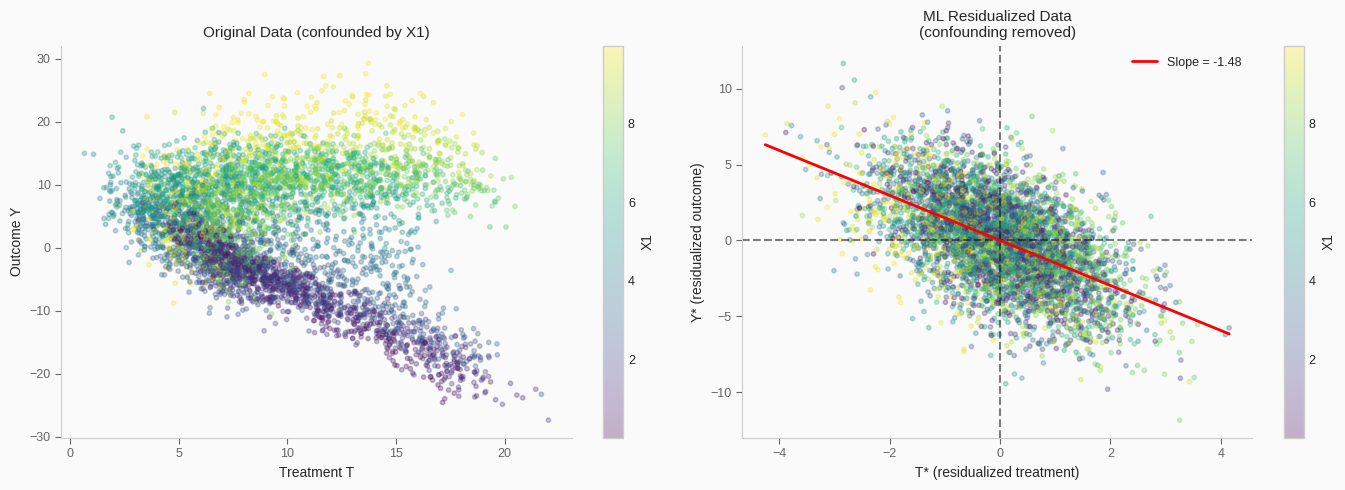

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data
ax = axes[0]
scatter = ax.scatter(data['T'], data['Y'], c=data['X1'], cmap='viridis', alpha=0.3, s=10)
plt.colorbar(scatter, ax=ax, label='X1')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('Original Data (confounded by X1)')
apply_tufte_style(ax)

# ML residualized data
ax = axes[1]
scatter = ax.scatter(T_star_naive, Y_star_naive, c=data['X1'], cmap='viridis', alpha=0.3, s=10)
plt.colorbar(scatter, ax=ax, label='X1')
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)

# Add regression line
x_line = np.linspace(T_star_naive.min(), T_star_naive.max(), 100)
ax.plot(x_line, tau_naive_ml * x_line, 'r-', linewidth=2, label=f'Slope = {tau_naive_ml:.2f}')
ax.set_xlabel('T* (residualized treatment)')
ax.set_ylabel('Y* (residualized outcome)')
ax.set_title('ML Residualized Data\n(confounding removed)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Insight ─────────────────────────────────────────────────────
ML residualization visibly removes confounding:
- Original data: X1 creates positive correlation
- Residualized data: Clear negative slope (true effect)

Note: The naive (same-sample) approach shown here has
overfitting issues. Cross-fitting is needed for valid inference.
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Comparing ML Models for Residualization

In [7]:
def ml_residualize(data, X_cols, T_col, Y_col, model_class, **model_kwargs):
    """Residualize Y and T using ML model (naive, same-sample).
    
    WARNING: This is for demonstration only. 
    Use cross-fitting for valid inference.
    """
    X = data[X_cols]
    T = data[T_col]
    Y = data[Y_col]
    
    # Fit models
    m_t = model_class(**model_kwargs)
    m_t.fit(X, T)
    T_star = T - m_t.predict(X)
    
    m_y = model_class(**model_kwargs)
    m_y.fit(X, Y)
    Y_star = Y - m_y.predict(X)
    
    # Estimate tau
    tau = np.sum(T_star * Y_star) / np.sum(T_star**2)
    
    return tau, T_star, Y_star

# Compare different ML models
results = {
    'Linear': tau_linear,
}

# Random Forest
tau_rf, _, _ = ml_residualize(data, X_cols, 'T', 'Y', 
                              RandomForestRegressor, n_estimators=100, max_depth=5, random_state=42)
results['Random Forest'] = tau_rf

# Gradient Boosting
tau_gb, _, _ = ml_residualize(data, X_cols, 'T', 'Y',
                              GradientBoostingRegressor, n_estimators=100, max_depth=3, random_state=42)
results['Gradient Boosting'] = tau_gb

# Display results
print(f"True τ = {TRUE_TAU}")
print("\nEstimated τ by method:")
for method, tau in results.items():
    bias = tau - TRUE_TAU
    print(f"  {method:20s}: τ = {tau:7.4f}, bias = {bias:+7.4f}")

True τ = -2.0

Estimated τ by method:
  Linear              : τ = -1.9673, bias = +0.0327
  Random Forest       : τ = -1.4813, bias = +0.5187
  Gradient Boosting   : τ = -1.8957, bias = +0.1043


### Real Data: Ice Cream Pricing

In [8]:
# Load real data
prices = load_facure_data("ice_cream_sales.csv")

# Linear residualization
m_t_lin = smf.ols("price ~ cost + temp + C(weekday)", data=prices).fit()
m_y_lin = smf.ols("sales ~ cost + temp + C(weekday)", data=prices).fit()
T_star_lin = prices['price'] - m_t_lin.predict(prices)
Y_star_lin = prices['sales'] - m_y_lin.predict(prices)
tau_lin = np.sum(T_star_lin * Y_star_lin) / np.sum(T_star_lin**2)

# ML residualization (Random Forest)
X_cols = ['cost', 'temp', 'weekday']
m_t_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
m_t_rf.fit(prices[X_cols], prices['price'])
T_star_rf = prices['price'] - m_t_rf.predict(prices[X_cols])

m_y_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
m_y_rf.fit(prices[X_cols], prices['sales'])
Y_star_rf = prices['sales'] - m_y_rf.predict(prices[X_cols])

tau_rf = np.sum(T_star_rf * Y_star_rf) / np.sum(T_star_rf**2)

print("Ice Cream Price Elasticity (naive, same-sample):")
print(f"  Linear residualization: τ = {tau_lin:.4f}")
print(f"  RF residualization:     τ = {tau_rf:.4f}")
print("\nBoth show NEGATIVE elasticity (makes economic sense!)")

Ice Cream Price Elasticity (naive, same-sample):
  Linear residualization: τ = -4.0004
  RF residualization:     τ = -3.8359

Both show NEGATIVE elasticity (makes economic sense!)


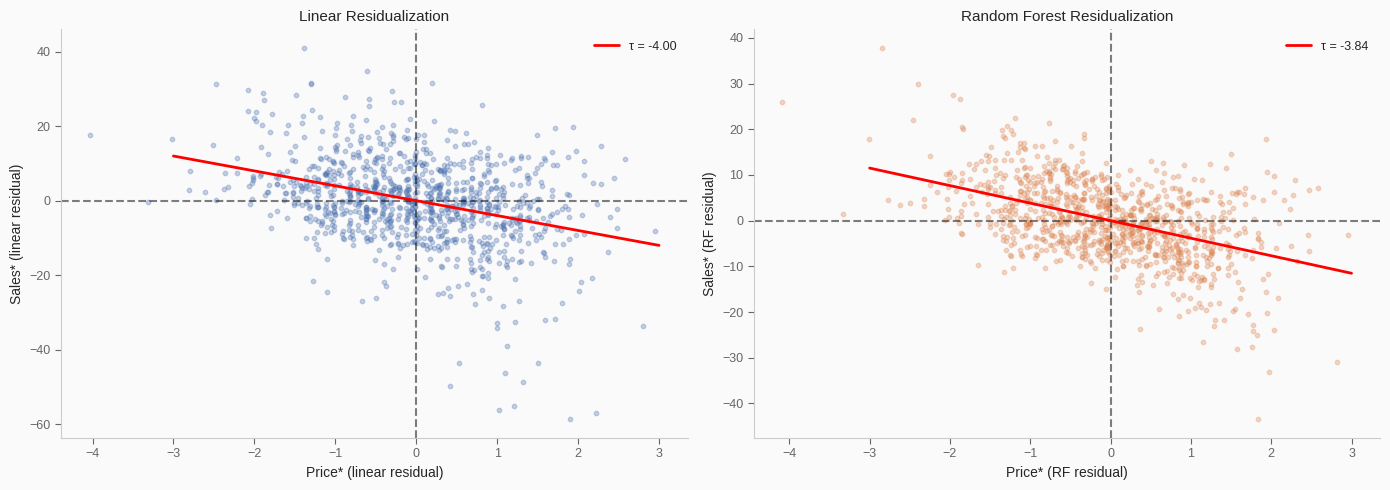

In [9]:
# Compare visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear
ax = axes[0]
sample_idx = np.random.choice(len(prices), 1000, replace=False)
ax.scatter(T_star_lin.iloc[sample_idx], Y_star_lin.iloc[sample_idx], alpha=0.3, s=10, c=COLORS['blue'])
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
x_line = np.linspace(-3, 3, 100)
ax.plot(x_line, tau_lin * x_line, 'r-', linewidth=2, label=f'τ = {tau_lin:.2f}')
ax.set_xlabel('Price* (linear residual)')
ax.set_ylabel('Sales* (linear residual)')
ax.set_title('Linear Residualization')
ax.legend()
apply_tufte_style(ax)

# Random Forest
ax = axes[1]
ax.scatter(T_star_rf.iloc[sample_idx], Y_star_rf.iloc[sample_idx], alpha=0.3, s=10, c=COLORS['orange'])
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.plot(x_line, tau_rf * x_line, 'r-', linewidth=2, label=f'τ = {tau_rf:.2f}')
ax.set_xlabel('Price* (RF residual)')
ax.set_ylabel('Sales* (RF residual)')
ax.set_title('Random Forest Residualization')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Key Takeaway ────────────────────────────────────────────────
ML residualization extends FWL to nonparametric settings:

1. **Replace linear models with ML** for E[T|X] and E[Y|X]
2. **Captures nonlinearities** and interactions automatically
3. **Final regression still simple** (Y* on T*)
4. **Critical issue**: Must use cross-fitting to avoid overfitting

Next notebook: Why cross-fitting is essential.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What is the partial linear model and why is it useful?

<details>
<summary>Solution</summary>

**Model**:
$$Y = \tau T + g(X) + \epsilon$$
$$T = m(X) + \nu$$

**Features**:
- Treatment effect $\tau$ is parametric (single coefficient)
- Confounding $g(X)$ and $m(X)$ are nonparametric (unknown functions)
- "Partial" because only part is parametric

**Why useful**:
1. Allows flexible confounding control without specifying functional form
2. Treatment effect remains interpretable
3. Can use ML for nuisance functions
4. Foundation for Double/Debiased ML

**Estimation via Robinson transform**:
$$\tilde{Y} = \tau \tilde{T} + \tilde{\epsilon}$$

</details>

### Q2: Why can we use ML models for residualization?

<details>
<summary>Solution</summary>

**FWL requires only** that residuals are orthogonal to controls:
- $E[\tilde{T} | X] = 0$ (treatment residual uncorrelated with X)
- $E[\tilde{Y} | X] = 0$ (outcome residual uncorrelated with X)

**Any consistent estimator** of $E[T|X]$ and $E[Y|X]$ achieves this:
- Linear regression: consistent if linear specification correct
- ML models: consistent under regularity conditions
- Both produce residuals orthogonal to X

**ML advantages**:
- Captures nonlinear relationships
- Handles high-dimensional X
- Data-driven (no manual specification)

**Caveat**: Need cross-fitting to avoid overfitting bias.

</details>

### Q3: What happens if the treatment model overfits?

<details>
<summary>Solution</summary>

**Overfitting** means $\hat{m}(X) \approx T$ on training data.

**Consequences**:
1. $\hat{T}^* = T - \hat{m}(X) \approx 0$
2. Very little treatment variation remains
3. Denominator $\sum \hat{T}^{*2} \approx 0$
4. $\hat{\tau}$ becomes unstable or undefined

**Intuition**: If we perfectly predict T from X, there's no "as-if-random" variation left.

**Solution**: Cross-fitting
- Fit model on fold A
- Predict on fold B
- Prevents overfitting because model hasn't seen prediction data

</details>

### Q4: Why must the outcome model be regression, not classification?

<details>
<summary>Solution</summary>

**For binary T or Y**, it's tempting to use classification.

**Why regression is required**:

1. **We need E[T|X], not P(T=1|X)... actually, these are the same for binary T!**
   - For binary T: $E[T|X] = P(T=1|X)$
   - Classification probability IS the conditional expectation

2. **The real issue**: Classification outputs discrete classes, not probabilities
   - If using `predict()` instead of `predict_proba()`, residuals are discrete
   - Discrete residuals break FWL assumptions

3. **For continuous Y**: Classification doesn't apply at all
   - Must use regression to get $E[Y|X]$

**Best practice**: Always use regression (or classification probabilities for binary).

</details>

### Q5: How do you choose which ML model to use for residualization?

<details>
<summary>Solution</summary>

**Guiding principle**: Good prediction → good residualization.

**Model selection criteria**:
1. **Predictive performance** (cross-validated R²)
2. **Computational cost** (especially for bootstrapping)
3. **Interpretability** (if you want to understand nuisance functions)

**Common choices**:
- Random Forest: Robust, handles interactions, parallelizable
- Gradient Boosting: Often best performance, slower
- Lasso: Good for sparse, high-dimensional X
- Neural Networks: For very large datasets

**Robustness approach**: Use multiple models, check if results are similar.

**Double robustness**: Combine PS and outcome regression (DR estimator).

</details>

---

## 6. References {#references}

[^1]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression.
      *Econometrica*, 56(4), 931-954.

[^2]: Chernozhukov, V., et al. (2018). Double/Debiased Machine Learning for
      Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix:
      Debiasing with Orthogonalization.